In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

CHEN_DATA_DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
CHEN_FILE_STEM = f'Supplementary_Data_2' # chen scores for 1kb windows

PUBLIC_REPO = 'constraint-tools-data'
PUBLIC_REPO_DIR = f'/scratch/ucgd/lustre-work/quinlan/u6018199/{PUBLIC_REPO}'

SUFFIXES = ['gnocchi', 'N_observed', 'K_bar', 'N_expected_gnocchi'] # K_bar >> 1 indicates negative selection 

import pandas as pd
import numpy as np 

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

plt.rcParams['font.size'] = 16

In [2]:
def get_gnocchi_and_GC_content(window_size): 
  filename = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}.GC_content_{window_size}.bed'  
  df = pd.read_csv(
    filename, 
    sep='\t',
  )
  return df 

get_gnocchi_and_GC_content(window_size=1000)

,window_chrom,window_start,window_end,chen_chrom,chen_start,chen_end,chen_score,window_GC_content
0,chr1,782999,784000,chr1,783000,784000,1.355101,0.319680
1,chr1,783999,785000,chr1,784000,785000,1.745145,0.314685
2,chr1,785999,787000,chr1,786000,787000,4.388539,0.365634
3,chr1,786999,788000,chr1,787000,788000,1.893217,0.375624
4,chr1,791999,793000,chr1,792000,793000,2.075487,0.390609
...,...,...,...,...,...,...,...,...
1984895,chr9,138137999,138139000,chr9,138138000,138139000,3.777362,0.557443
1984896,chr9,138138999,138140000,chr9,138139000,138140000,4.693755,0.603397
1984897,chr9,138157999,138159000,chr9,138158000,138159000,1.646564,0.406593
1984898,chr9,138209999,138211000,chr9,138210000,138211000,2.748850,0.479520


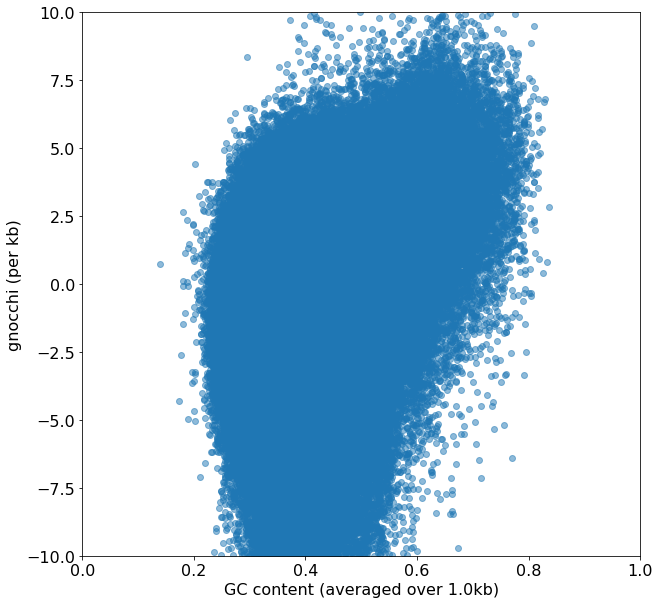

<ipython-input-7-516cccf691b9>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2


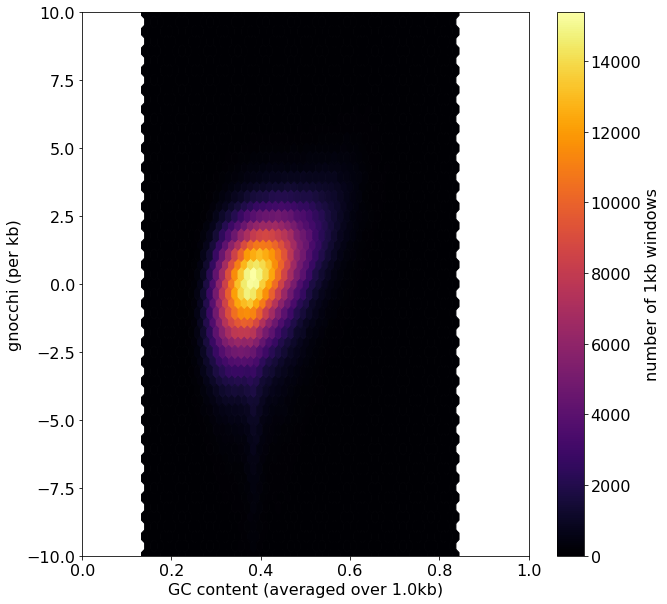

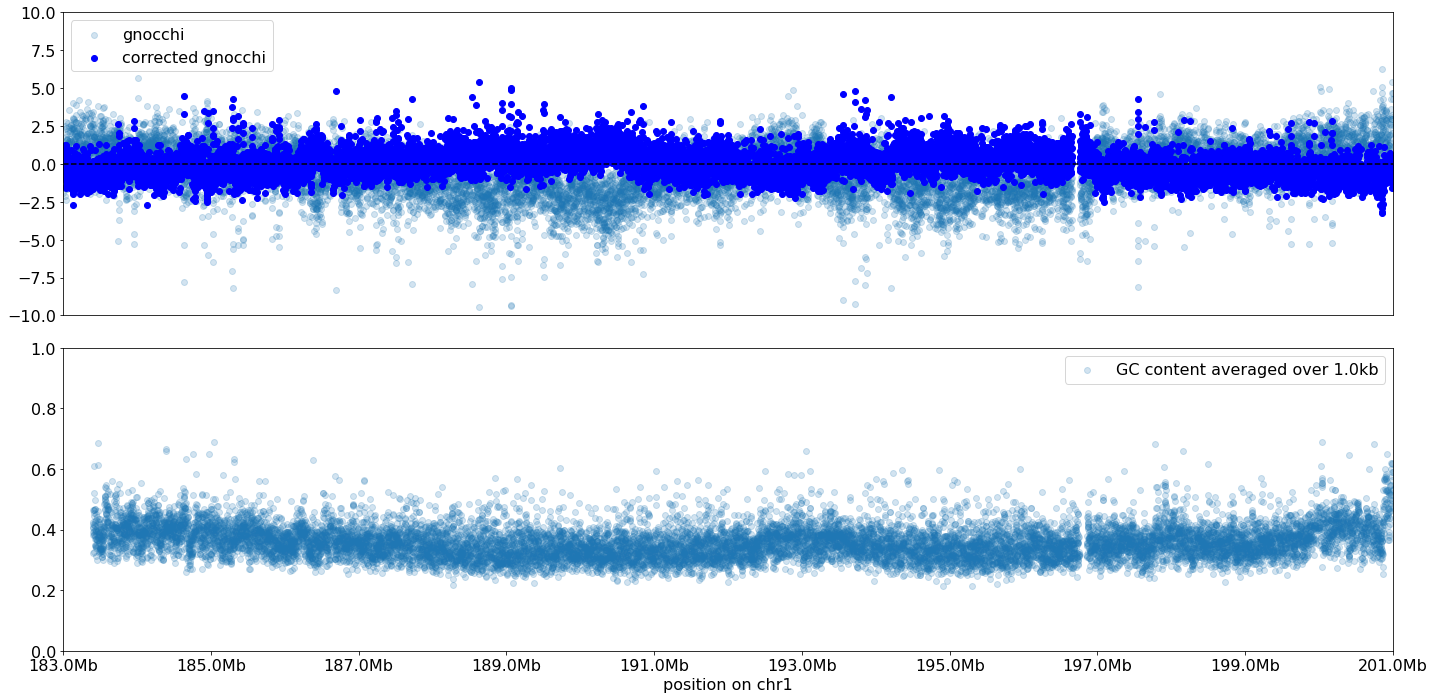

In [7]:
from matplotlib.pyplot import plot


def correct_gnocchi(df, window_size):
  GC = np.array(df['window_GC_content'])
  gnocchi = np.array(df['chen_score'])

  plt.figure(figsize=(10, 10))
  plt.scatter(GC, gnocchi, alpha=0.5)
  plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
  plt.ylabel('gnocchi (per kb)')
  plt.xlim(0, 1)
  plt.ylim(-10, 10)
  plt.show()

  plt.figure(figsize=(10, 10))
  hb = plt.hexbin(GC, gnocchi, gridsize=50, cmap='inferno')
  cb = plt.colorbar(hb)
  cb.set_label('number of 1kb windows')
  plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
  plt.ylabel('gnocchi (per kb)')
  plt.xlim(0, 1)
  plt.ylim(-10, 10)

  X = GC.reshape(-1, 1)
  y = gnocchi

  model_mean = LinearRegression()
  model_mean.fit(X, y)
  predicted_mean = model_mean.predict(X)

  residuals = y - predicted_mean

  # Predict the variance using the squared residuals
  model_variance = LinearRegression()
  model_variance.fit(X, residuals**2)
  predicted_variance = model_variance.predict(X)

  df['corrected_chen_score'] = (predicted_mean - y) / np.sqrt(predicted_variance)

  return df

def round_to_nearest_million(x):
  multiple = x / 1e6
  multiple = round(multiple)
  return int(multiple * 1e6)

def plot_gnocchi(df, chromosome, start, end, window_size, tick_interval=2e6):
  df = df[df['window_chrom'] == chromosome] 

  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2
  df = df[
    (df['chen_center'] > start) &
    (df['chen_center'] < end)
  ]

  x = np.array(df['chen_center'])
  y = np.array(df['chen_score'])
  y_corrected = np.array(df['corrected_chen_score'])
  GC = np.array(df['window_GC_content'])

  fig, axs = plt.subplots(2, figsize=(20, 10))

  axs[0].scatter(x, y, label='gnocchi', alpha=0.2)
  axs[0].scatter(x, y_corrected, color='blue', label='corrected gnocchi')
  axs[0].set_xlim(start, end)
  axs[0].set_ylim(-10, 10)
  axs[0].set_xticks([])
  axs[0].legend()

  axs[1].scatter(x, GC, label=f'GC content averaged over {window_size/1000}kb', alpha=0.2)
  axs[1].set_xlabel(f'position on {chromosome}')
  axs[1].set_xlim(start, end)
  axs[1].set_ylim(0, 1)
  axs[1].legend()

  smallest_tick = round_to_nearest_million(min(x)) 
  largest_tick = round_to_nearest_million(max(x))
  xticks = np.arange(smallest_tick, largest_tick+1, tick_interval)
  axs[1].set_xticks(xticks)

  formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6}Mb')
  axs[1].xaxis.set_major_formatter(formatter)

  axs[0].plot([start, end], [0, 0], color='black', linestyle='--')

  plt.tight_layout()
  plt.show()

def correct_and_plot_gnocchi(chromosome, start, end, window_size, tick_interval=2e6):
  df = get_gnocchi_and_GC_content(window_size)

  df = correct_gnocchi(df, window_size)

  plot_gnocchi(df, chromosome, start, end, window_size, tick_interval)

correct_and_plot_gnocchi(chromosome='chr1', start=183400000, end=201000000, window_size=1000)

## z-score does depend on GC content at small length scales, as expected since z-score depends on gene presence, and that correlates with GC content.


In [4]:
# TODO: create plots for this 

## z-score depends on GC content evaluated at large length scales, which is worrying...

In [5]:
# TODO: create plots for this 

## Validation

In [6]:
# TODO 

# 2. is corrected gnocchi still higher, on average, in coding vs noncoding genome? 
# 3. Visualize the cleaned-up z-score in the browser, and test its performance using Chen’s original validation metrics 
